# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [1]:
import os
import warnings
from glob import glob

# Import new things that we'll need
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import seaborn as sns

import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
from nilearn.image import resample_to_img
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
from nilearn import plotting, image
import nibabel as nb
import datetime

%matplotlib inline

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)

### I next want to get a list of all of my functional files

In [30]:
sid = ['01'] # sorry in my bids I labelled subject as 01, not 21
base_dir = '/home/fzaki001/Mattfeld_PSB6351/'
work_dir = '/home/fzaki001/scratch-bbr/psb6351/'
func_dir = os.path.join(base_dir, f'bids_dataset/sub-{sid[0]}/func')
fmap_dir = os.path.join(base_dir, f'bids_dataset/sub-{sid[0]}/fmap')
fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
assert len(func_json) > 0, "Check your bold json path! No files were found!"

func_files = sorted(glob(func_dir + '/*.nii.gz'))
assert len(func_files) > 0, "Check your bold scan path! No files were found!"

fmap_files = sorted(glob(fmap_dir + '/*bold*.nii.gz'))
assert len(fmap_files) > 0, "Check your bold fmap path! No files were found!"

In [10]:
func_files[0]

'/home/fzaki001/Mattfeld_PSB6351/bids_dataset/sub-01/func/sub-01_run-1-task_bold.nii.gz'

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [33]:
# Note that I've removed all HW4-unrelated comments for clarity

# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    assert len(func_files) > 0, "Input has no files!"
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(
    Function(
        input_names=['func_files'],
        output_names=['subs'],
        function=get_subs
    ),
    name='getsubs'
)
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume. I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(
    afni.OutlierCount(),
    name = 'id_outliers'
)
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 (changed to all available) volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(
    Function(
        input_names=['outlier_count'],
        output_names=['best_vol_num'],
        function=best_vol # this is the function we've defined before
    ),
    name='getbestvol' # this is the name we give to this part of the pipeline
)
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(
    fsl.ExtractROI(t_size=1),
    name = "extractref"
)
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

volreg = pe.MapNode(
    afni.Volreg(),
    iterfield=['in_file'],
    name = 'volreg',
)
volreg.inputs.outputtype = 'NIFTI_GZ'
volreg.inputs.zpad = 4
volreg.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg, 'basefile')

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter',)
tshifter.inputs.tr = '1.76'
tshifter.inputs.slice_timing = slice_timing_list
tshifter.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(volreg, 'out_file', tshifter, 'in_file')

# BBRegister node for coregistration
bbregister = pe.Node(fs.BBRegister(
    init='fsl',
    contrast_type = 't2',
    out_fsl_file = True,
    subject_id = sid[0],
    subjects_dir = fs_dir,
    registered_file=True,
), name ='bbregister')

psb6351_wf.connect([
    (extractref, bbregister, [('roi_file', 'source_file')]),
])

# Add spatial smoothing with multiple fwhm kernels 
smooth = pe.MapNode(
    interface=fsl.SUSAN(),
    name='smooth',
    iterfield=['in_file']
)
smooth.iterables = ('fwhm', [3, 6, 9])  # This will create separate streams for each kernel
smooth.inputs.output_type = 'NIFTI_GZ'

psb6351_wf.connect([
(tshifter, smooth, [('out_file', 'in_file')]),
])

# Add high-pass temporal filtering
highpass = pe.MapNode(
    interface=fsl.TemporalFilter(),
    iterfield=['in_file'],
    name='highpass'
)
# calculate highpass sigma in volumes
TR = 1.76
cutoff_secs = 100 # this means I want remove everything slower that 1/100 = 0.01 Hz 
highpass_sigma = cutoff_secs /  TR  # I do this because fsl asks cutoff in volumes, so the window of about 100 seconds in TR is needed
highpass.inputs.highpass_sigma = highpass_sigma

psb6351_wf.connect([
(smooth, highpass, [('smoothed_file', 'in_file')]),
])

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc/') # full means the run where I take all slices for outlier function
datasink.inputs.container = f'sub-{sid[0]}'

psb6351_wf.connect([
    (volreg, datasink, [('out_file', 'motion.@corrfile')]),
    (volreg, datasink, [('oned_matrix_save', 'motion.@matrix')]),
    (volreg, datasink, [('oned_file', 'motion.@par')]),
    (tshifter, datasink, [('out_file', 'sltime_corr')]),
    (extractref, datasink, [('roi_file', 'study_ref')]),
    (bbregister, datasink, [('out_reg_file', 'reg.@reg_file')]),
    (bbregister, datasink, [('out_fsl_file', 'reg.@fsl_file')]),
    (bbregister, datasink, [('registered_file', 'reg.@reg_image')]),
    (smooth, datasink, [('smoothed_file', 'smooth.@smooth')]),
    (highpass, datasink, [('out_file', 'filtered.@filtered')]),
    (getsubs, datasink, [('subs', 'substitutions')]),
])

# psb6351_wf.write_graph(
#     dotfilename=f"graph_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S.%f')}.dot",
#     graph2use='hierarchical',
#     format='png',
#     simple_form=True,
# )

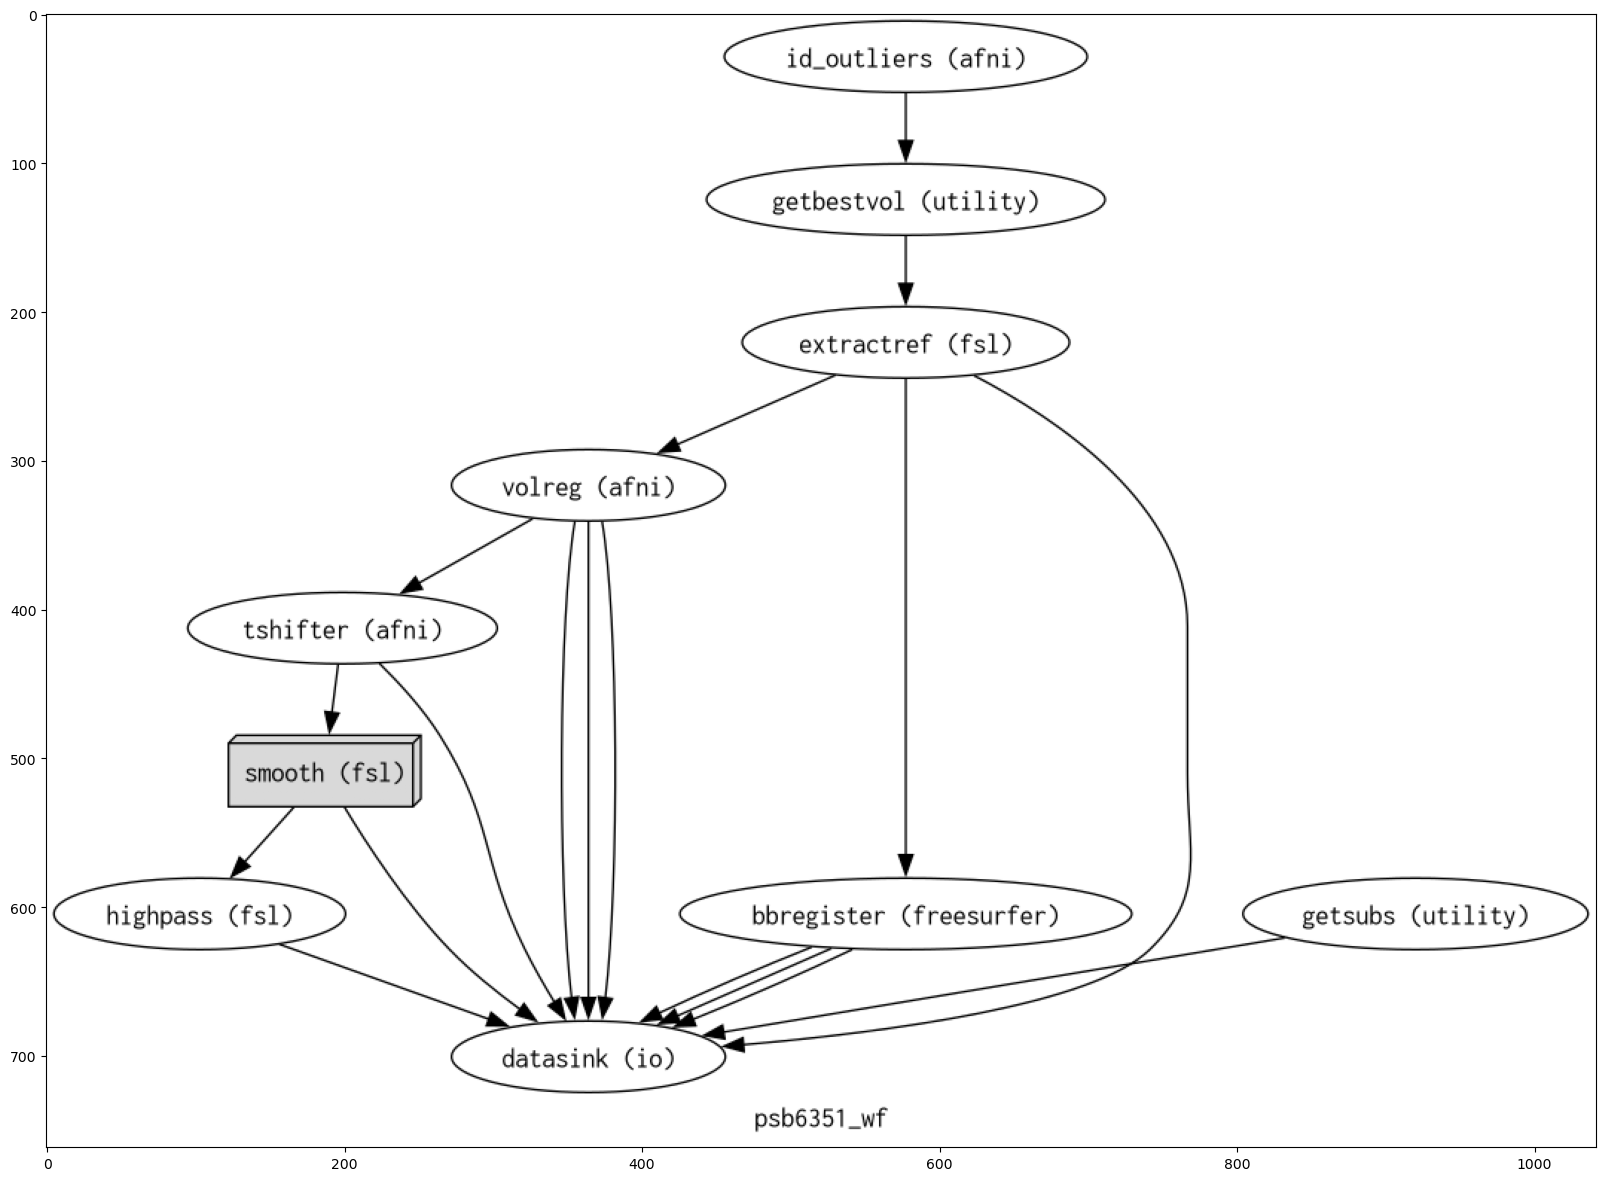

In [5]:
# this is how the pipeline is structured per nipype
plt.figure(figsize = (20,20))
img = mpimg.imread(glob("/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/graph*.png",)[2])
imgplot = plt.imshow(img)
plt.show()

In [34]:
psb6351_wf.run()

241027-21:04:10,136 nipype.workflow INFO:
	 Workflow psb6351_wf settings: ['check', 'execution', 'logging', 'monitoring']
241027-21:04:10,350 nipype.workflow INFO:
	 Running serially.
241027-21:04:10,356 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.id_outliers" in "/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/id_outliers".
241027-21:04:10,402 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.id_outliers" - collecting precomputed outputs
241027-21:04:10,403 nipype.workflow INFO:
	 [Node] "psb6351_wf.id_outliers" found cached.
241027-21:04:10,404 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.getsubs" in "/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/getsubs".
241027-21:04:10,426 nipype.workflow INFO:
	 [Node] Cached "psb6351_wf.getsubs" - collecting precomputed outputs
241027-21:04:10,427 nipype.workflow INFO:
	 [Node] "psb6351_wf.getsubs" found cached.
241027-21:04:10,428 nipype.workflow INFO:
	 [Node] Setting-up "psb6351_wf.

In [35]:
# here we can see smoothing applied for all runs (here 3mm fwhm folder is shown)
!tree /home/fzaki001/Mattfeld_PSB6351/derivatives/preproc/sub-01/smooth/_fwhm_3/

/home/fzaki001/Mattfeld_PSB6351/derivatives/preproc/sub-01/smooth/_fwhm_3/
├── _smooth0
│   └── sub-01_run-1-task_bold_volreg_tshift_smooth.nii.gz
├── _smooth1
│   └── sub-01_run-1_loc_bold_volreg_tshift_smooth.nii.gz
├── _smooth2
│   └── sub-01_run-2-task_bold_volreg_tshift_smooth.nii.gz
├── _smooth3
│   └── sub-01_run-2_loc_bold_volreg_tshift_smooth.nii.gz
├── _smooth4
│   └── sub-01_run-3-task_bold_volreg_tshift_smooth.nii.gz
└── _smooth5
    └── sub-01_run-4-task_bold_volreg_tshift_smooth.nii.gz

6 directories, 6 files


### Now I want to look at how my smooting and filtering look

In [21]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('/home/fzaki001/scratch-bbr/psb6351/psb6351workdir/sub-01/psb6351_wf/getbestvol/result_getbestvol.pklz')
best_vol_num = res.outputs.best_vol_num

In [27]:
no_smoothing = nb.load(
    glob(f"{base_dir}derivatives/preproc/sub-01/sltime_corr/*.nii.gz"
)[0]).slicer[:, :, :, best_vol_num]

fwhm_3 = nb.load(
    glob(f"{base_dir}derivatives/preproc/sub-01/smooth/_fwhm_3/_smooth0/*.nii.gz"
)[0]).slicer[:, :, :, best_vol_num] # choosing the best volume,
                                    # it's not very important here but still have to choose only one
fwhm_6 = nb.load(
    glob(f"{base_dir}derivatives/preproc/sub-01/smooth/_fwhm_6/_smooth0/*.nii.gz"
)[0]).slicer[:, :, :, best_vol_num]

fwhm_9 = nb.load(
    glob(f"{base_dir}derivatives/preproc/sub-01/smooth/_fwhm_9/_smooth0/*.nii.gz"
)[0]).slicer[:, :, :, best_vol_num]

fwhm_12 = nb.load(
    glob(f"{base_dir}derivatives/preproc/sub-01/smooth/_fwhm_12/_smooth0/*.nii.gz"
)[0]).slicer[:, :, :, best_vol_num]

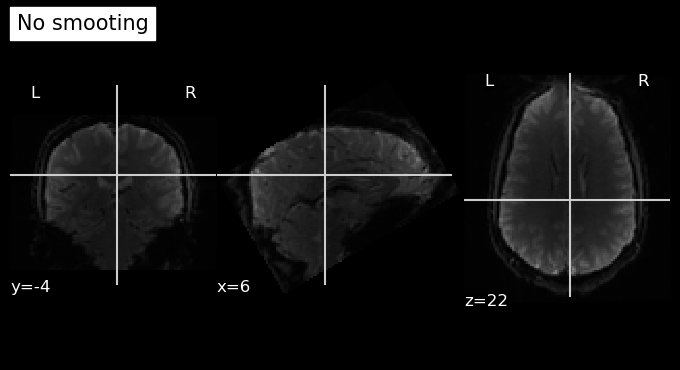

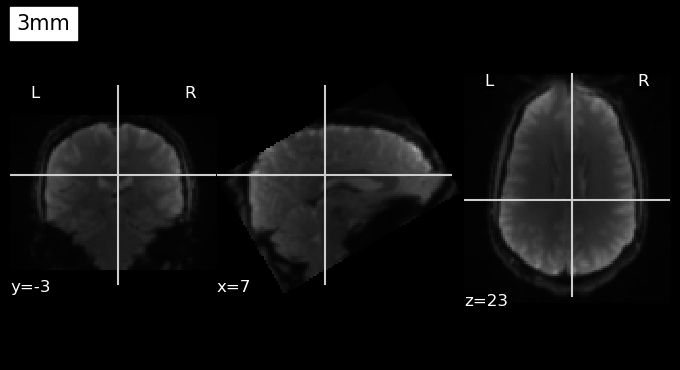

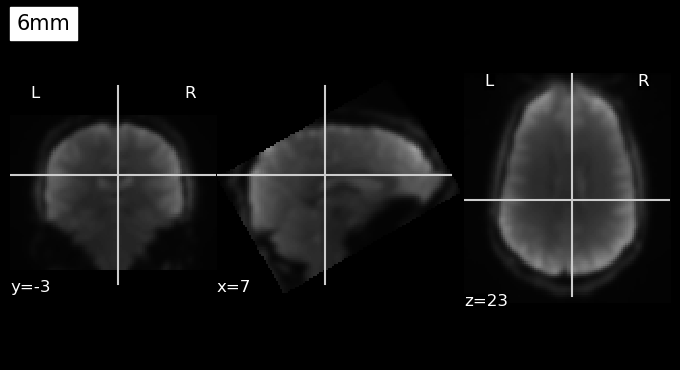

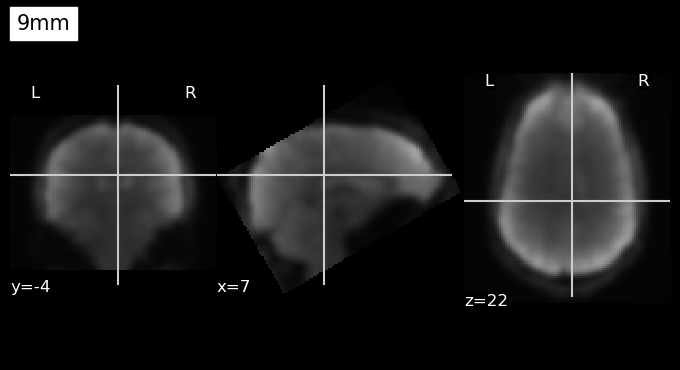

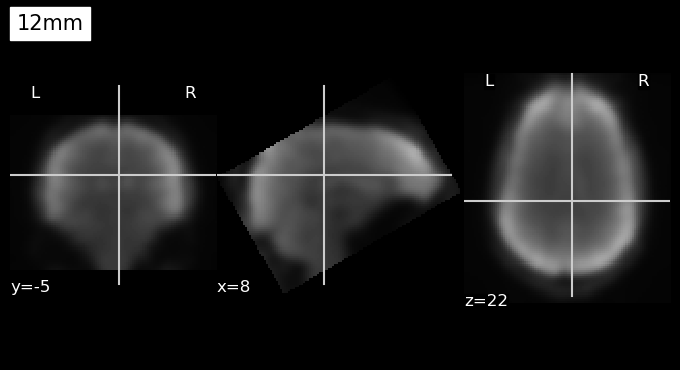

In [28]:
# Ok it looks as it should
plotting.plot_anat(no_smoothing, display_mode='ortho', cmap='gray', title="No smooting")
plotting.plot_anat(fwhm_3, display_mode='ortho', cmap='gray', title="3mm")
plotting.plot_anat(fwhm_6, display_mode='ortho', cmap='gray', title="6mm")
plotting.plot_anat(fwhm_9, display_mode='ortho', cmap='gray', title="9mm")
plotting.plot_anat(fwhm_12, display_mode='ortho', cmap='gray', title="12mm")

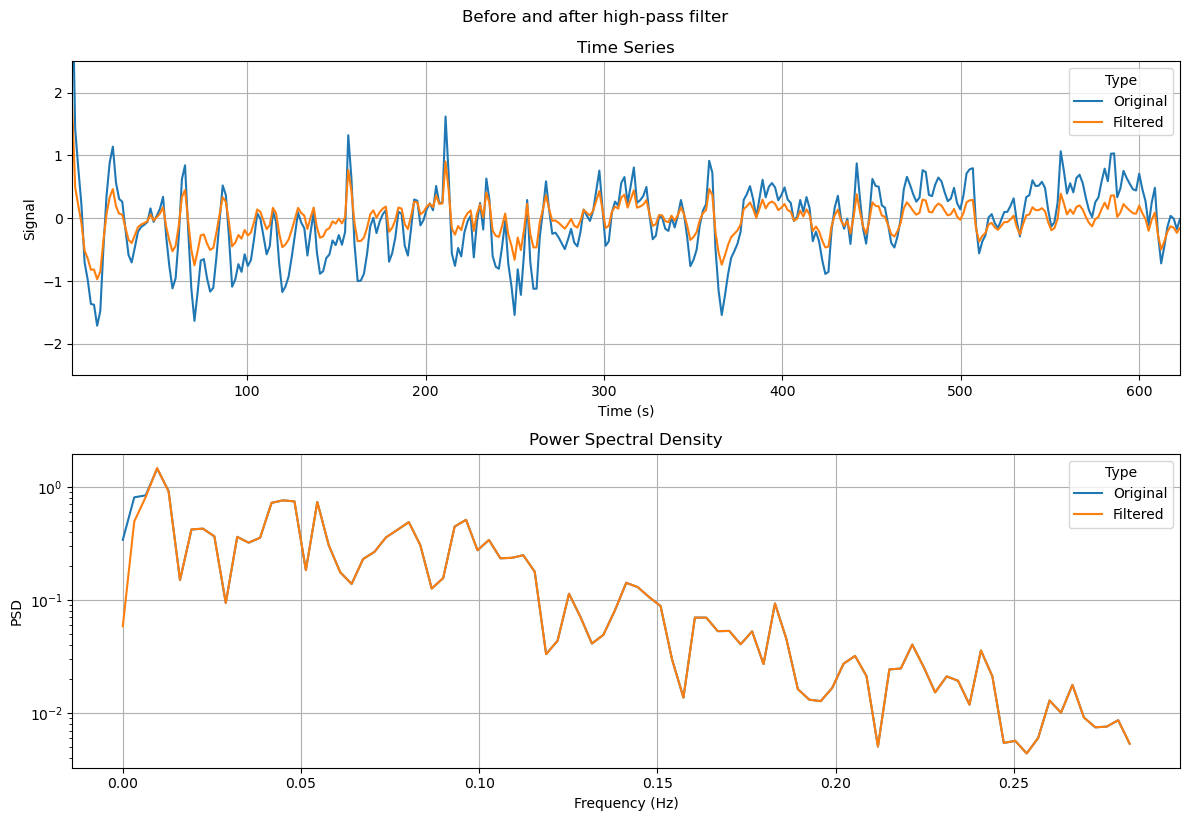

In [83]:
# Although I've filtered all FWHM variations,
# I will go ahead with 6mm and plot if before and after filter
# I'd like to look at just timeseries signal and PSD
import seaborn as sns
from scipy import signal

def load_and_extract_timeseries(filepath, roi_coords=None):

    img = nb.load(filepath)
    data = img.get_fdata()
    if roi_coords is None:
        # if no roi provided, take mean across all brain voxels
        timeseries = np.mean(data, axis=(0,1,2))
    else:
        timeseries = data[roi_coords[0], roi_coords[1], roi_coords[2], :]
    return timeseries

def calculate_psd(timeseries, tr):

    freqs, psd = signal.welch(timeseries, fs=1/tr, nperseg=len(timeseries)//2)
    mask = freqs >= 0
    return freqs[mask], psd[mask]
    
def plot_comparison(original_ts, filtered_ts, tr, title=None):

    time = np.arange(len(original_ts)) * tr

    freqs_orig, psd_orig = calculate_psd(original_ts, tr)
    freqs_filt, psd_filt = calculate_psd(filtered_ts, tr)

    original_ts = [(i - np.mean(original_ts)) / np.std(original_ts) for i in original_ts] # z-score
   
    df_time = pd.DataFrame({
        'Time (s)': np.concatenate([time, time]),
        'Signal': np.concatenate([original_ts, filtered_ts]),
        'Type': ['Original']*len(time) + ['Filtered']*len(time)
    })
    
    df_freq = pd.DataFrame({
        'Frequency (Hz)': np.concatenate([freqs_orig, freqs_filt]),
        'PSD': np.concatenate([psd_orig, psd_filt]),
        'Type': ['Original']*len(freqs_orig) + ['Filtered']*len(freqs_filt)
    })
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    sns.lineplot(data=df_time, x='Time (s)', y='Signal', hue='Type', ax=ax1)
    ax1.set_title('Time Series')
    ax1.set_ylim(-2.5, 2.5)
    ax1.set_xlim(2, df_time['Time (s)'].max())
    ax1.grid()
    
    sns.lineplot(data=df_freq, x='Frequency (Hz)', y='PSD', hue='Type', ax=ax2)
    ax2.set_title('Power Spectral Density')
    # ax2.set_xlim(0.01, 0.1)
    # ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid()
   
    plt.tight_layout()
    if title:
        fig.suptitle(title, y=1.02)
    
    return fig

roi_coords = (4, 22, 30) # first was trying to look at rois but they looked weird so I just average everything
tr = 1.76

original_data = load_and_extract_timeseries(glob(
    f"{base_dir}derivatives/preproc/sub-01/smooth/_fwhm_6/_smooth0/*.nii.gz"
)[0])
filtered_data = load_and_extract_timeseries(glob(
    f"{base_dir}derivatives/preproc/sub-01/filtered/_fwhm_6/_highpass0/*.nii.gz"
)[0])

fig = plot_comparison(
    original_data[:],
    filtered_data[:], 
    tr=tr,
    title=f'Before and after high-pass filter'
)
# plt.savefig(f'comparison_kernel_{kernel}mm.png', dpi=300, bbox_inches='tight')
# plt.close()

# This looks pretty much what I expected, very low frequencies (0.01 Hz and lower) were dropped
# can be seen both on the timeseries and PSD
# all high frequency oscillations are preserved

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


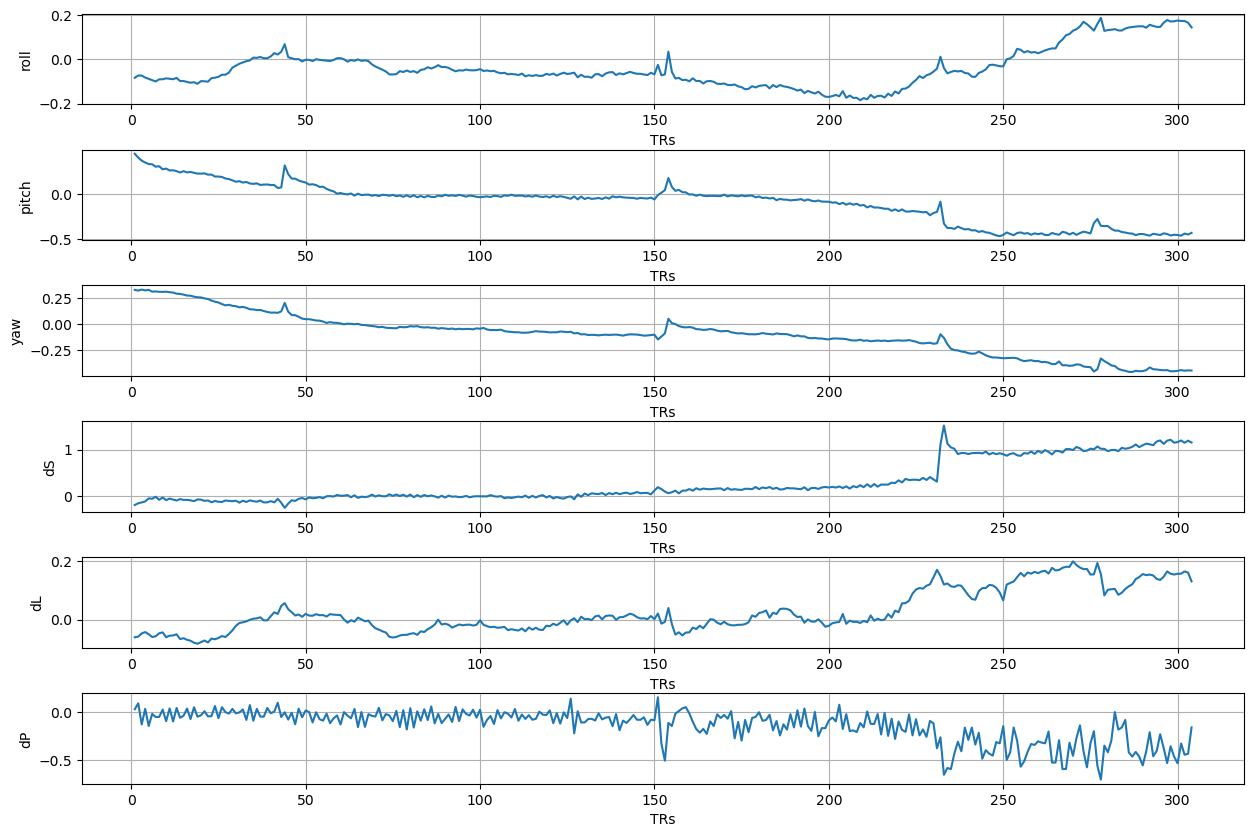

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


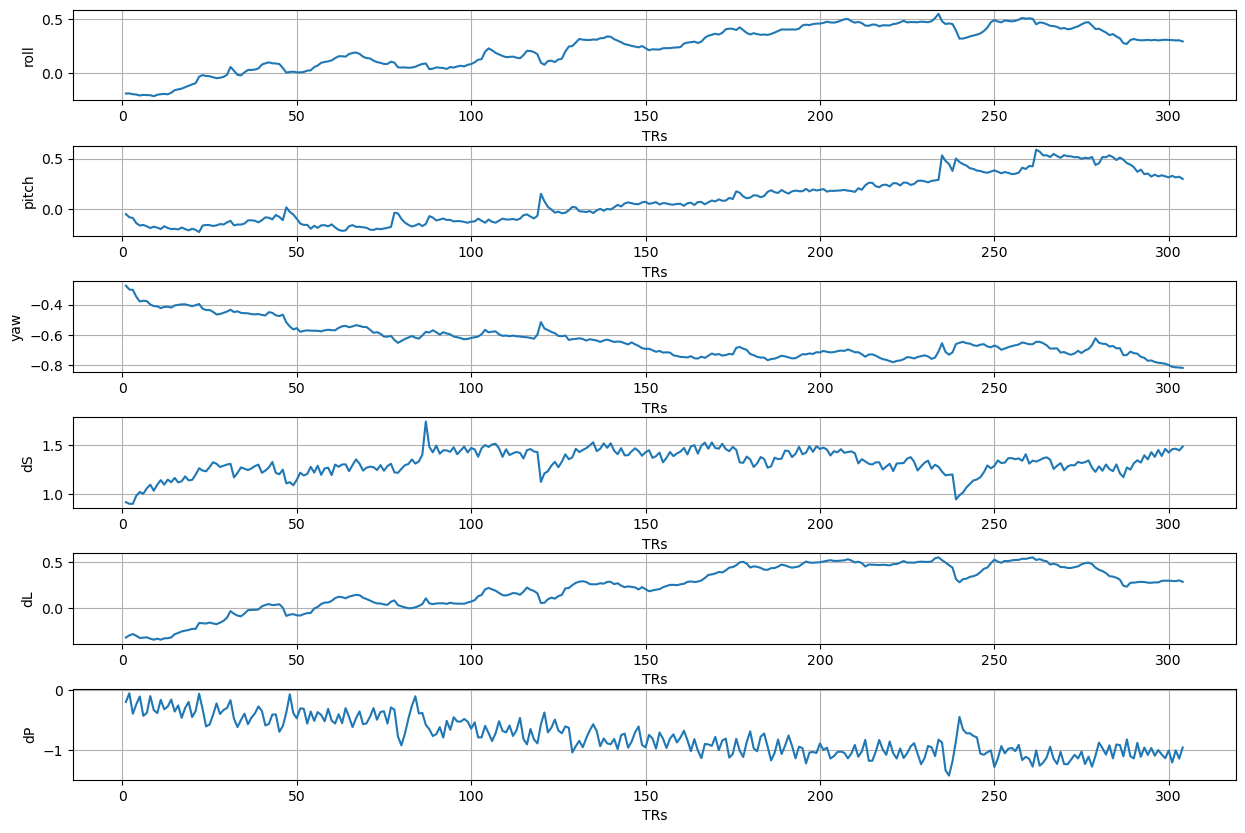

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


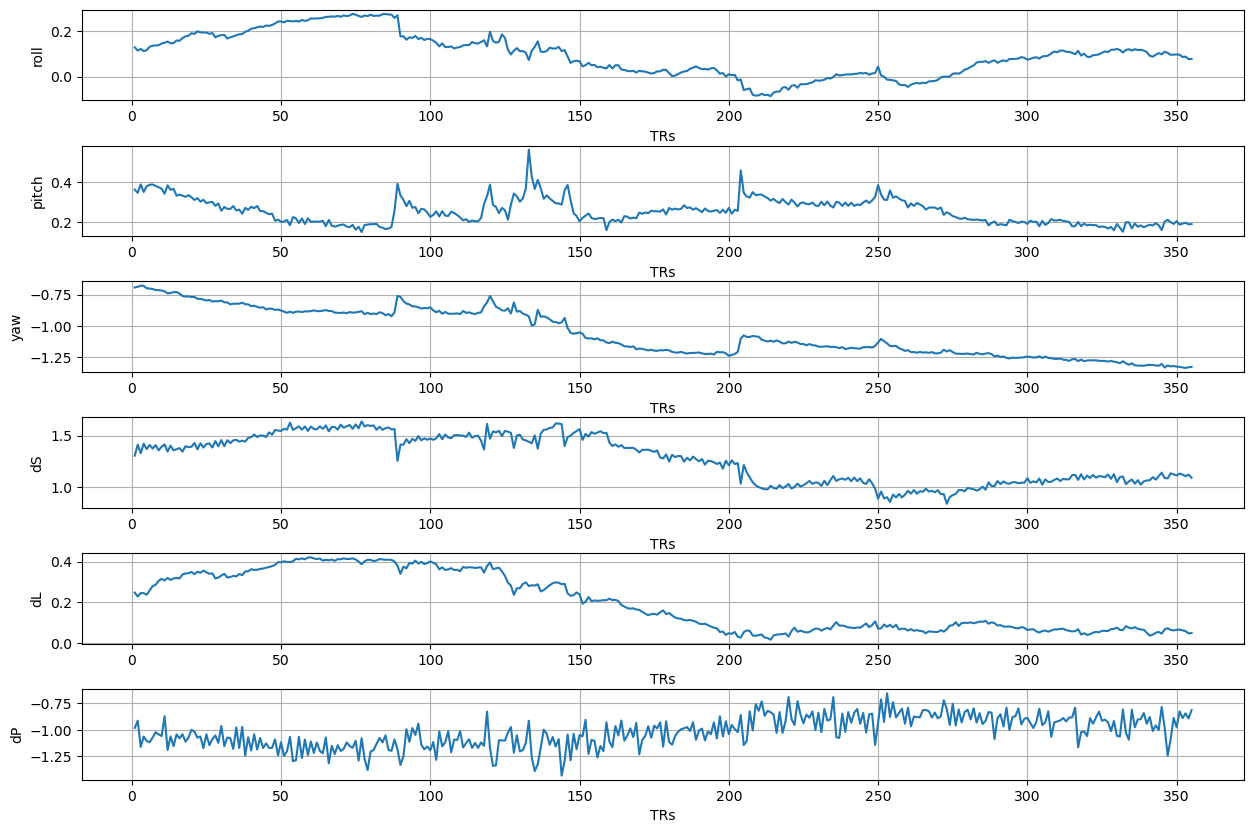

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


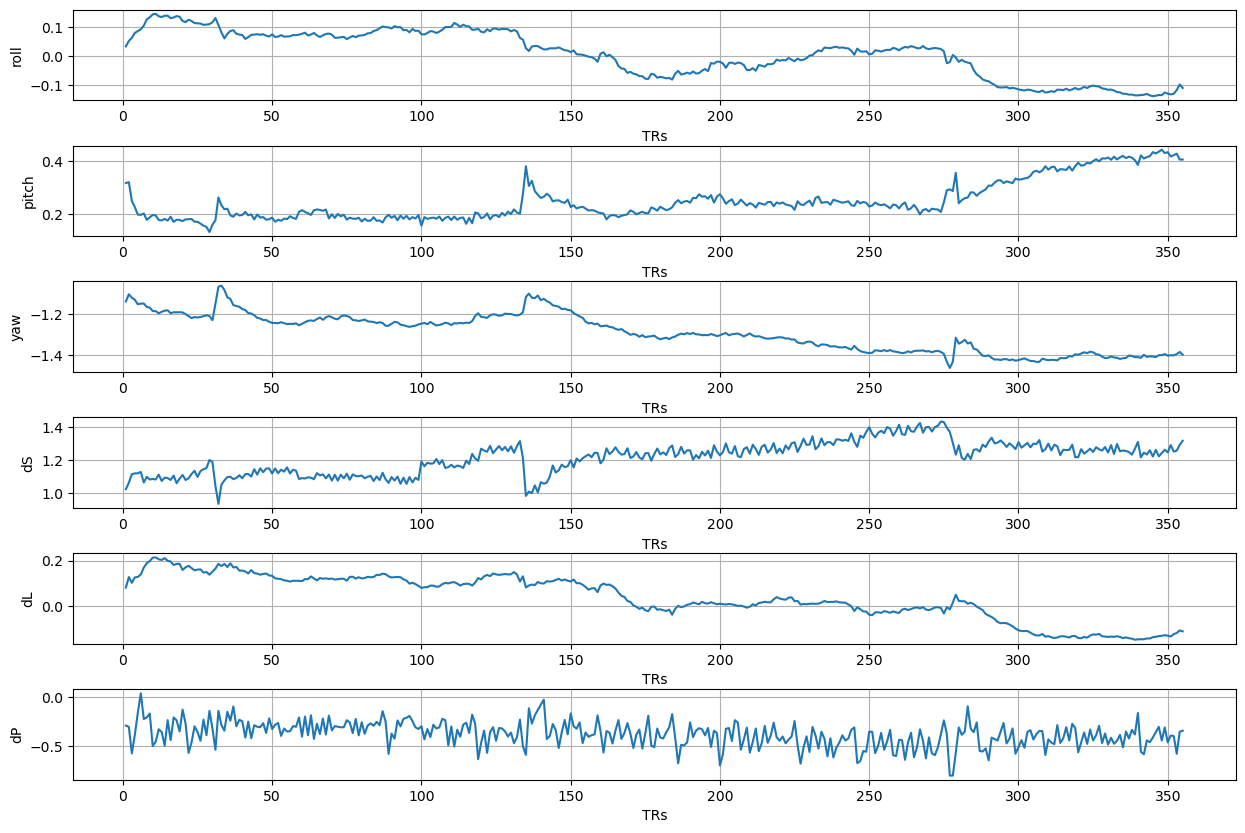

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


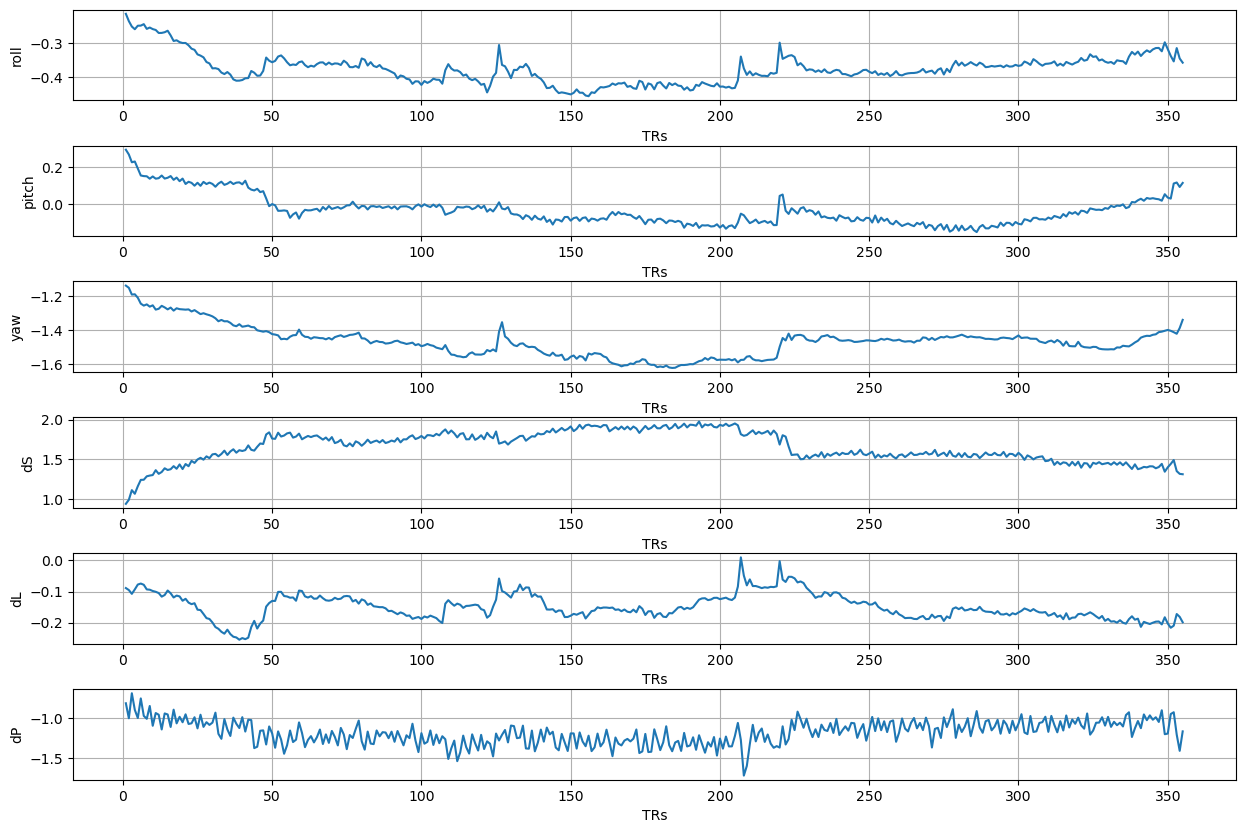

/tmp/ipykernel_98586/3524838209.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


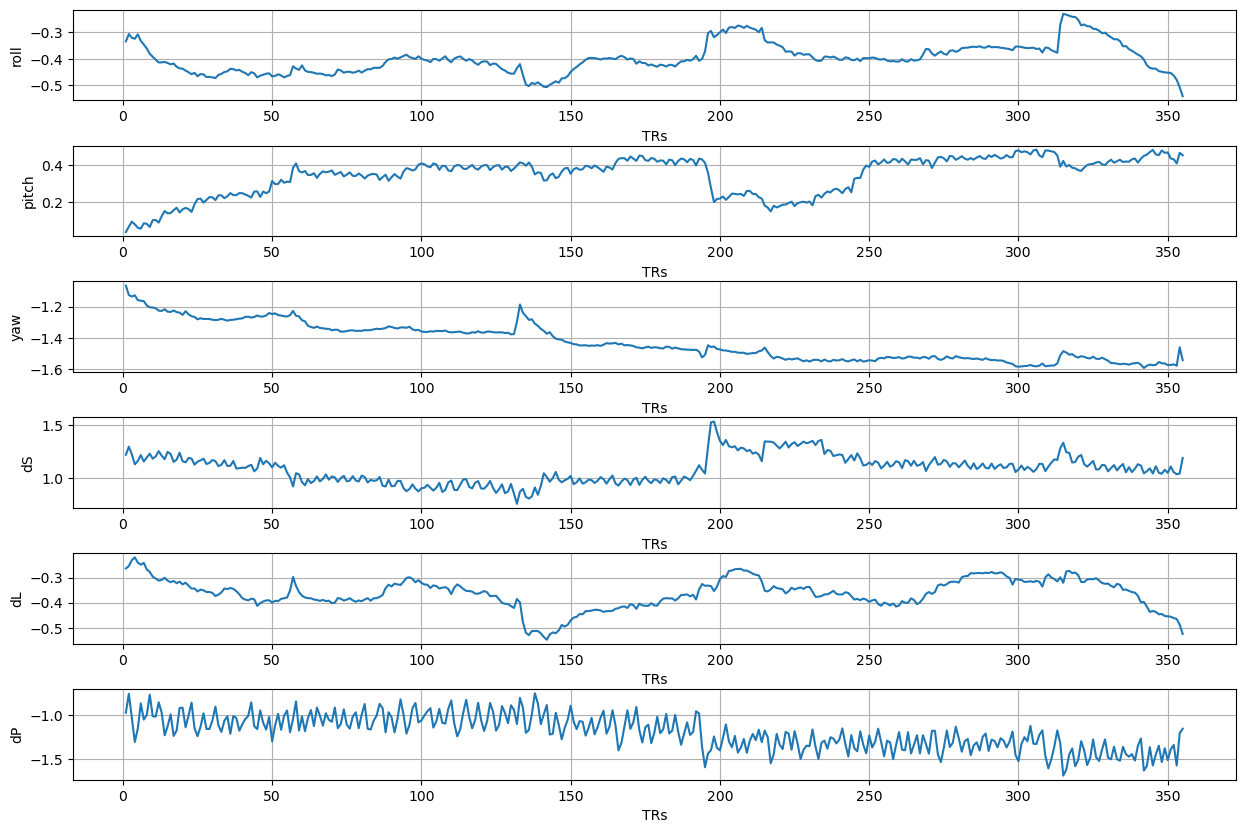

In [7]:
fig_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/figs'
motion_dir = f'{base_dir}derivatives/preproc_full/sub-{sid[0]}/motion'
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))
# study_motion_files = sorted(glob(motion_dir + '/*_bold_tshift.1D')) # I needed this when reversed the order 
                                                                    # slice timing correction and motion correction

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df = (motion_df - motion_df.mean())/motion_df.std() # I'm not sure how common it is, but I standardized all motion values in all axes
                                                            # so that by visual inspection we can spot "significant outliers"
                                                            # and also have the same scale across all plots
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']

    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    filename = curr_mot_file.split('/')[-1].split('.')[0]
    fig.suptitle(filename)
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        data = motion_df[curr_col].values
        axs[idx].plot(
            [tr * 1.76 for tr in num_vols], # converted TR to time to make it more similar to the carpet plots below
            data,
        )
        axs[idx].set_xlabel('time (s)')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].legend(loc='upper left')
        axs[idx].set_ylim(-4, 4) # ylim applied to all plots to be able to set 2sd and 3sd thresholds
        axs[idx].grid(True)
    # plt.show()
        time = [tr * 1.76 for tr in num_vols]
        for i in range(len(data) - 1):
            if data[i] > 2 or data[i] < -2:
                axs[idx].axvspan(time[i], time[i + 1], color='orange', alpha=0.3, label = "±2sd")
            if data[i] > 3 or data[i] < -3:
                axs[idx].axvspan(time[i], time[i + 1], color='red', alpha=0.3, label = "±3sd")
        custom_lines = [
            Line2D([0], [0], color='orange', alpha=0.3, lw=10, label='±2sd'),
            Line2D([0], [0], color='red', alpha=0.3, lw=10, label='±3sd')
        ]
        axs[idx].legend(handles=custom_lines, loc='upper left')
        
    plt.tight_layout()
    plt.savefig(f"{fig_dir+'/'}{filename}_motion_tseries_{datetime.datetime.now()}.pdf")
    plt.show()

In [ ]:
from nilearn.plotting import plot_carpet
from nilearn import masking

# Build an EPI-based mask because we have no anatomical data

num_files = len(func_files)
num_cols = 3 
num_rows = (num_files + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, func_file in enumerate(func_files):
    mask_img = masking.compute_epi_mask(func_file)
    
    display = plot_carpet(
        func_files[0],
        mask_img,
        t_r=1.76,
        standardize="zscore_sample",
        title=f"global patterns over time for file {func_file.split('/')[-1].split('.')[0]}",
        axes=axes[i],
    )
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig(f"{fig_dir+'/'}carpet_plots_{datetime.datetime.now()}.png")
plt.show()

In [ ]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast'''
    subs = []
    for curr_run in range(len(func_files)):
        subs.append(('_tshifter%d' %curr_run, ''))
        subs.append(('_volreg%d' %curr_run, ''))
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

# HW3 - change the search window. how does this impact your results?
def best_vol(outlier_count):
    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    if isinstance(best_vol_num, list):
        best_vol_num = best_vol_num[0]
    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information?
####################################
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['PICK THE RIGHT COLUMN?'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
id_outliers = pe.Node(afni.OutlierCount(),
                      name = 'id_outliers')
####################################
# HW3 - what happens if you chose a different func_file?  How does it impact results
# Is the first func file the best way to go?
####################################
id_outliers.inputs.in_file = func_files[0]
id_outliers.inputs.automask = True
id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
getbestvol = pe.Node(Function(input_names=['outlier_count'],
                              output_names=['best_vol_num'],
                              function=best_vol),
                     name='getbestvol')
psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
extractref = pe.Node(fsl.ExtractROI(t_size=1),
                     name = "extractref")
####################################
# HW3 - if you choose a different func file...should this change too?
# If yes, why?  what should it change to?
####################################
extractref.inputs.in_file = func_files[0]
psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# Below is the command that runs AFNI's 3dvolreg command.
# this is the node that performs the motion correction
# I'm iterating over the functional files which I am passing
# functional data from the slice timing correction node before
# I'm using the earliest volume with the least number of outliers
# during the first run as the base file to register to.

####################################
# HW3 - what happens when you change the order of the following two nodes?
# How does that impact your results?
# Run things again with the order reversed and save in a new sink folder without deleting your first
####################################
volreg1st = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
volreg1st.inputs.outputtype = 'NIFTI_GZ'
volreg1st.inputs.zpad = 4
volreg1st.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', volreg1st, 'basefile')

mcflirt1st = pe.MapNode(fsl.MCFLIRT(),
                    iterfield=['in_file'],
                    name = 'volreg')
mcflirt1st.inputs.output_type = 'NIFTI_GZ'
mcflirt1st.inputs.in_file = func_files
psb6351_wf.connect(extractref, 'roi_file', mcflirt1st, 'ref_file')

# Below is the command that runs AFNI's 3dTshift command
# this is the node that performs the slice timing correction
# I input the study func files as a list and the slice timing 
# as a list of lists. I'm using a MapNode to iterate over the two.
# this should allow me to parallelize this on the HPC
tshifter2nd = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
tshifter2nd.inputs.tr = '1.76'
tshifter2nd.inputs.slice_timing = slice_timing_list
tshifter2nd.inputs.outputtype = 'NIFTI_GZ'
psb6351_wf.connect(volreg1st, 'out_file', tshifter2nd, 'in_file')

tshifter1st = pe.MapNode(afni.TShift(),
                      iterfield=['in_file','slice_timing'],
                      name = 'tshifter')
tshifter1st.inputs.tr = '1.76'
tshifter1st.inputs.slice_timing = slice_timing_list
tshifter1st.inputs.outputtype = 'NIFTI_GZ'
tshifter1st.inputs.in_file = func_files

volreg2nd = pe.MapNode(afni.Volreg(),
                    iterfield=['in_file'],
                    name = 'volreg')
volreg2nd.inputs.outputtype = 'NIFTI_GZ'
volreg2nd.inputs.zpad = 4
psb6351_wf.connect(extractref, 'roi_file', volreg2nd, 'basefile')
psb6351_wf.connect(tshifter1st, 'out_file', volreg2nd, 'in_file')

# HW4 Add a coregistration node to coregister functional to structural
# make sure to connect node appropriately and to sink the data
# in the datasink below appropriately...required...sink the transformation matrix

# Below is the node that collects all the data and saves
# the outputs that I am interested in. Here in this node
# I use the substitutions input combined with the earlier
# function to get rid of nesting
datasink = pe.Node(nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join(base_dir, 'derivatives/preproc')
datasink.inputs.container = f'sub-{sid[0]}'
psb6351_wf.connect(tshifter2nd, 'out_file', datasink, 'sltime_corr2nd')
psb6351_wf.connect(extractref, 'roi_file', datasink, 'study_ref')
psb6351_wf.connect(volreg1st, 'out_file', datasink, 'motion1stAFNI.@corrfile')
psb6351_wf.connect(volreg1st, 'oned_matrix_save', datasink, 'motion1stAFNI.@matrix')
psb6351_wf.connect(volreg1st, 'oned_file', datasink, 'motion1stAFNI.@par')
psb6351_wf.connect(getsubs, 'subs', datasink, 'substitutions')

psb6351_wf.connect(mcflirt1st, 'mat_file', datasink, 'motion1stFSL.@matrix')
psb6351_wf.connect(mcflirt1st, 'par_file', datasink, 'motion1stFSL.@par')
psb6351_wf.connect(mcflirt1st, 'out_file', datasink, 'motion1stFSL.@corrfile')

psb6351_wf.connect(tshifter1st, 'out_file', datasink, 'sltime_corr1st')
psb6351_wf.connect(volreg2nd, 'out_file', datasink, 'motionn2nd.@corrfile')
psb6351_wf.connect(volreg2nd, 'oned_matrix_save', datasink, 'motion2nd.@matrix')
psb6351_wf.connect(volreg2nd, 'oned_file', datasink, 'motion2nd.@par')

# The following lines set a work directory outside of my 
# local git repo and runs the workflow
psb6351_wf.run()
#psb6351_wf.run(plugin='SLURM',
#               plugin_args={'sbatch_args': ('--partition IB_44C_512G --qos pq_madlab --account acc_madlab'),
#                            'overwrite':True})